# Project 

In [180]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

**Data Description...**

In [181]:
food_inspections = pd.read_csv('data/food-inspections.csv', sep=',')

**Drop the columns we don't need**

We don't need the location since we already have the latitude and longitude columns. 
The Zip codes are not required either.

In [182]:
food_inspections = food_inspections.drop(['Zip', 'Zip Codes','Historical Wards 2003-2015', 'Community Areas', 'Census Tracts','Wards'], axis=1)

In [183]:
food_inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2320830,"THE HOXTON, CHICAGO","THE HOXTON, CHICAGO",2694640.0,Restaurant,Risk 2 (Medium),200 N GREEN ST,CHICAGO,IL,2019-10-31T00:00:00.000,License,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.885699,-87.648789,"{'latitude': '-87.64878908937915', 'longitude'..."
1,2320831,OGDEN PLAZA INC.,OGDEN PLAZA INC.,2475982.0,Grocery Store,Risk 3 (Low),3459 W OGDEN AVE,CHICAGO,IL,2019-10-31T00:00:00.000,Canvass,Out of Business,NaN,41.855266,-87.712402,"{'latitude': '-87.71240156240032', 'longitude'..."
2,2320829,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689756.0,Grocery Store,Risk 3 (Low),3455-3459 S OGDEN AVE,CHICAGO,IL,2019-10-31T00:00:00.000,License,Not Ready,NaN,NaN,NaN,NaN
3,2320813,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689757.0,Grocery Store,Risk 3 (Low),3455-3459 S OGDEN AVE,CHICAGO,IL,2019-10-31T00:00:00.000,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,NaN,NaN,NaN
4,2320757,GADS HILL CENTER,GADS HILL CENTER,2698627.0,Daycare Above and Under 2 Years,Risk 1 (High),4255-4259 S ARCHER AVE,CHICAGO,IL,2019-10-30T00:00:00.000,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.816005,-87.700893,"{'latitude': '-87.70089338917239', 'longitude'..."


In [184]:
food_inspections['DBA Name'].isnull().values.any()

False

**Check the cities**

We see that chicago is there several times. 

In [185]:
food_inspections.groupby('City')['DBA Name']\
    .count()\
    .sort_values(ascending=False)

City
CHICAGO               194278
Chicago                  320
chicago                   97
CCHICAGO                  46
SCHAUMBURG                24
                       ...  
COUNTRY CLUB HILLS         1
DES PLAINES                1
GRIFFITH                   1
alsip                      1
GLENCOE                    1
Name: DBA Name, Length: 71, dtype: int64

In [186]:
def city_clear(city):
    city = str(city).lower()
    if city == 'cchicago':
        city = 'chicago'
    return city  

food_inspections.City = food_inspections.City.apply(city_clear)

In [187]:
food_inspections.groupby('City')['DBA Name']\
    .count()\
    .sort_values(ascending=False)

City
chicago               194753
nan                      138
schaumburg                24
maywood                   16
elk grove village         13
                       ...  
country club hills         1
des plaines                1
griffith                   1
wilmette                   1
glencoe                    1
Name: DBA Name, Length: 66, dtype: int64

**Deleting other cities than Chicago**

We keep only chicago. Most data is overthere and the rest is not required. We check the state as well (different Chicago ?). At the end, we are sure to work only with restaurants in Chicago, Illinois.

In [188]:
food_inspections = food_inspections[food_inspections.City == 'chicago']

In [189]:
food_inspections.groupby('City')['DBA Name']\
    .count()\
    .sort_values(ascending=False)

City
chicago    194753
Name: DBA Name, dtype: int64

In [190]:
food_inspections.groupby('State')['DBA Name']\
    .count()\
    .sort_values(ascending=False)

State
IL    194730
Name: DBA Name, dtype: int64

In [191]:
food_inspections = food_inspections.drop(['City','State'], axis=1)

In [192]:
food_inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2320830,"THE HOXTON, CHICAGO","THE HOXTON, CHICAGO",2694640.0,Restaurant,Risk 2 (Medium),200 N GREEN ST,2019-10-31T00:00:00.000,License,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.885699,-87.648789,"{'latitude': '-87.64878908937915', 'longitude'..."
1,2320831,OGDEN PLAZA INC.,OGDEN PLAZA INC.,2475982.0,Grocery Store,Risk 3 (Low),3459 W OGDEN AVE,2019-10-31T00:00:00.000,Canvass,Out of Business,NaN,41.855266,-87.712402,"{'latitude': '-87.71240156240032', 'longitude'..."
2,2320829,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689756.0,Grocery Store,Risk 3 (Low),3455-3459 S OGDEN AVE,2019-10-31T00:00:00.000,License,Not Ready,NaN,NaN,NaN,NaN
3,2320813,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689757.0,Grocery Store,Risk 3 (Low),3455-3459 S OGDEN AVE,2019-10-31T00:00:00.000,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,NaN,NaN,NaN
4,2320757,GADS HILL CENTER,GADS HILL CENTER,2698627.0,Daycare Above and Under 2 Years,Risk 1 (High),4255-4259 S ARCHER AVE,2019-10-30T00:00:00.000,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.816005,-87.700893,"{'latitude': '-87.70089338917239', 'longitude'..."


**Checking the license numbers of restaurants**

We check if don't have duplicates. Some places were inspected several times and have thus multiple rows in the dataset. We want to count the number of inspections done on each establishment so we will transform the data set to make 'Establishment'-centric.

In [193]:
license_count = food_inspections.groupby("License #")\
    .count()\
    .sort_values(by='DBA Name', ascending=False).copy()

In [194]:
license_count['Inspection ID'].head()

License #
0.0          506
1354323.0    192
14616.0      176
1574001.0     83
1974745.0     59
Name: Inspection ID, dtype: int64

In [197]:
food_inspections.groupby("License #")['Inspection Date']\
    .count()\
    .sort_values(ascending=False)

License #
0.0          506
1354323.0    192
14616.0      176
1574001.0     83
1974745.0     59
            ... 
1621893.0      1
1621842.0      1
1621769.0      1
1621703.0      1
9999999.0      1
Name: Inspection Date, Length: 37125, dtype: int64

Problème à résoudre: license # = 0.0 et peut-être 1.0 non catégorisée. 

In [198]:
food_inspections[food_inspections['License #']==1]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
187686,250567,HARVEST CRUSADES MINISTRIES,HARVEST CRUSADES MINISTRIES,1.0,Special Event,Risk 2 (Medium),118 N CENTRAL AVE,2010-06-04T00:00:00.000,Special Events (Festivals),Pass,NaN,41.882845,-87.765095,"{'latitude': '-87.76509545204392', 'longitude'..."


We will considerate a license number of '0' equivalent to a missing value

In [199]:
food_inspections.replace(0, np.nan, inplace=True)
food_inspections['License #'].value_counts()

1354323.0    192
14616.0      176
1574001.0     83
1974745.0     59
1142451.0     49
            ... 
1145318.0      1
2233264.0      1
2583922.0      1
57813.0        1
2326981.0      1
Name: License #, Length: 37124, dtype: int64

We see now that the 0's are removed

**New Year format ?**

In [200]:
food_inspections['year'] = food_inspections['Inspection Date'].apply(lambda x: x.split('-')[0])
food_inspections['month'] = food_inspections['Inspection Date'].apply(lambda x: x.split('-')[1])
food_inspections['Inspection Date'] = food_inspections['month'] + '/' + food_inspections['year']
food_inspections = food_inspections.drop(['year','month'], axis=1)

In [201]:
food_inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2320830,"THE HOXTON, CHICAGO","THE HOXTON, CHICAGO",2694640.0,Restaurant,Risk 2 (Medium),200 N GREEN ST,10/2019,License,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.885699,-87.648789,"{'latitude': '-87.64878908937915', 'longitude'..."
1,2320831,OGDEN PLAZA INC.,OGDEN PLAZA INC.,2475982.0,Grocery Store,Risk 3 (Low),3459 W OGDEN AVE,10/2019,Canvass,Out of Business,NaN,41.855266,-87.712402,"{'latitude': '-87.71240156240032', 'longitude'..."
2,2320829,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689756.0,Grocery Store,Risk 3 (Low),3455-3459 S OGDEN AVE,10/2019,License,Not Ready,NaN,NaN,NaN,NaN
3,2320813,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689757.0,Grocery Store,Risk 3 (Low),3455-3459 S OGDEN AVE,10/2019,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,NaN,NaN,NaN
4,2320757,GADS HILL CENTER,GADS HILL CENTER,2698627.0,Daycare Above and Under 2 Years,Risk 1 (High),4255-4259 S ARCHER AVE,10/2019,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.816005,-87.700893,"{'latitude': '-87.70089338917239', 'longitude'..."


In [202]:
food_inspections['test'] = food_inspections['Inspection ID'].astype(str) + food_inspections['License #'].astype(str) + food_inspections['Inspection Date'].astype(str)
food_inspections.test.is_unique

False

In [151]:
print('Number of rows in dataset before deleting the duplicates: {}'.format(food_inspections.shape))
food_inspections = food_inspections.drop_duplicates(subset=['test'], keep=False)
print('Number of rows in dataset after deleting the duplicates: {}'.format(food_inspections.shape))

Number of rows in dataset before deleting the duplicates: (194753, 15)
Number of rows in dataset after deleting the duplicates: (194495, 15)


In [152]:
food_inspections = food_inspections.drop(['test'], axis=1)

**Nan values: Violations**

In [153]:
food_inspections[food_inspections.Violations.isnull()].head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Type,Results,Violations,Latitude,Longitude,Location,date
1,2320831,OGDEN PLAZA INC.,OGDEN PLAZA INC.,2475982.0,Grocery Store,Risk 3 (Low),3459 W OGDEN AVE,Canvass,Out of Business,NaN,41.855266,-87.712402,"{'latitude': '-87.71240156240032', 'longitude'...",10/2019
2,2320829,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689756.0,Grocery Store,Risk 3 (Low),3455-3459 S OGDEN AVE,License,Not Ready,NaN,NaN,NaN,NaN,10/2019
5,2320793,TACO MARIO'S LIMITED,TACO MARIO'S LIMITED,2622418.0,Mobile Food Preparer,Risk 2 (Medium),2300 S THROOP ST,License,Pass,NaN,41.850451,-87.658798,"{'latitude': '-87.65879785567869', 'longitude'...",10/2019
6,2320795,TBD,THE EXCHANGE,2698572.0,Restaurant,Risk 1 (High),300 N LA SALLE ST STE 110,License,Pass,NaN,41.887529,-87.632647,"{'latitude': '-87.63264683652446', 'longitude'...",10/2019
7,2320768,The Manor,The Manor,22971.0,Restaurant,Risk 1 (High),4152-4158 W 47TH ST,Canvass,No Entry,NaN,41.807924,-87.728164,"{'latitude': '-87.72816394877388', 'longitude'...",10/2019


In [154]:
food_inspections.head(60)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Type,Results,Violations,Latitude,Longitude,Location,date
0,2320830,"THE HOXTON, CHICAGO","THE HOXTON, CHICAGO",2694640.0,Restaurant,Risk 2 (Medium),200 N GREEN ST,License,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.885699,-87.648789,"{'latitude': '-87.64878908937915', 'longitude'...",10/2019
1,2320831,OGDEN PLAZA INC.,OGDEN PLAZA INC.,2475982.0,Grocery Store,Risk 3 (Low),3459 W OGDEN AVE,Canvass,Out of Business,NaN,41.855266,-87.712402,"{'latitude': '-87.71240156240032', 'longitude'...",10/2019
2,2320829,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689756.0,Grocery Store,Risk 3 (Low),3455-3459 S OGDEN AVE,License,Not Ready,NaN,NaN,NaN,NaN,10/2019
3,2320813,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689757.0,Grocery Store,Risk 3 (Low),3455-3459 S OGDEN AVE,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,NaN,NaN,NaN,10/2019
4,2320757,GADS HILL CENTER,GADS HILL CENTER,2698627.0,Daycare Above and Under 2 Years,Risk 1 (High),4255-4259 S ARCHER AVE,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.816005,-87.700893,"{'latitude': '-87.70089338917239', 'longitude'...",10/2019
5,2320793,TACO MARIO'S LIMITED,TACO MARIO'S LIMITED,2622418.0,Mobile Food Preparer,Risk 2 (Medium),2300 S THROOP ST,License,Pass,NaN,41.850451,-87.658798,"{'latitude': '-87.65879785567869', 'longitude'...",10/2019
6,2320795,TBD,THE EXCHANGE,2698572.0,Restaurant,Risk 1 (High),300 N LA SALLE ST STE 110,License,Pass,NaN,41.887529,-87.632647,"{'latitude': '-87.63264683652446', 'longitude'...",10/2019
7,2320768,The Manor,The Manor,22971.0,Restaurant,Risk 1 (High),4152-4158 W 47TH ST,Canvass,No Entry,NaN,41.807924,-87.728164,"{'latitude': '-87.72816394877388', 'longitude'...",10/2019
8,2320762,VIREVA NURSEY SCHOOL,VIREVA NURSEY SCHOOL,2215871.0,Children's Services Facility,Risk 1 (High),1935 W 51ST ST,License Re-Inspection,Pass,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,41.801134,-87.673444,"{'latitude': '-87.6734440144631', 'longitude':...",10/2019
9,2320719,"4884 S ARCHER INC,.","4884 S ARCHER INC,.",2678088.0,Grocery Store,Risk 3 (Low),4884 S ARCHER AVE,License,Fail,NaN,41.804621,-87.719907,"{'latitude': '-87.71990706549693', 'longitude'...",10/2019


In [155]:
food_inspections_no_violations = food_inspections.copy()
print(food_inspections_no_violations.shape)
food_inspections_no_violations = food_inspections_no_violations[food_inspections_no_violations['Violations'].notna()]
#pourquoi pas: food_inspections_no_violations = food_inspections[food_inspections['Violations'].notna()].copy()
#copie directement que la slice qui nous intéresse

(194495, 14)


In [156]:
food_inspections_no_violations.shape

(142986, 14)

In [157]:
viola_count = food_inspections_no_violations.groupby("License #")['Violations']\
    .count()
viola_count = pd.DataFrame(viola_count)
viola_count

,Violations
License #,
2.0,14
9.0,14
40.0,17
62.0,15
85.0,3
...,...
3808691.0,3
3808890.0,1
3846027.0,1


In [158]:
food_inspections = food_inspections.merge(viola_count, on="License #", how='outer')\
    .rename(columns={'Violations_x':'Violations','Violations_y':'Violation Count'})

In [159]:
food_inspections.shape

(194495, 15)

In [160]:
food_inspections[food_inspections.Violations.isnull()].head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Type,Results,Violations,Latitude,Longitude,Location,date,Violation Count
1,2320831,OGDEN PLAZA INC.,OGDEN PLAZA INC.,2475982.0,Grocery Store,Risk 3 (Low),3459 W OGDEN AVE,Canvass,Out of Business,NaN,41.855266,-87.712402,"{'latitude': '-87.71240156240032', 'longitude'...",10/2019,1.0
3,2320829,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689756.0,Grocery Store,Risk 3 (Low),3455-3459 S OGDEN AVE,License,Not Ready,NaN,NaN,NaN,NaN,10/2019,NaN
6,2320793,TACO MARIO'S LIMITED,TACO MARIO'S LIMITED,2622418.0,Mobile Food Preparer,Risk 2 (Medium),2300 S THROOP ST,License,Pass,NaN,41.850451,-87.658798,"{'latitude': '-87.65879785567869', 'longitude'...",10/2019,2.0
9,2320795,TBD,THE EXCHANGE,2698572.0,Restaurant,Risk 1 (High),300 N LA SALLE ST STE 110,License,Pass,NaN,41.887529,-87.632647,"{'latitude': '-87.63264683652446', 'longitude'...",10/2019,NaN
10,2320768,The Manor,The Manor,22971.0,Restaurant,Risk 1 (High),4152-4158 W 47TH ST,Canvass,No Entry,NaN,41.807924,-87.728164,"{'latitude': '-87.72816394877388', 'longitude'...",10/2019,20.0


In [161]:
food_inspections['Violation Count'].fillna(0, inplace=True)

In [162]:
food_inspections[food_inspections.Violations.isnull()].head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Type,Results,Violations,Latitude,Longitude,Location,date,Violation Count
1,2320831,OGDEN PLAZA INC.,OGDEN PLAZA INC.,2475982.0,Grocery Store,Risk 3 (Low),3459 W OGDEN AVE,Canvass,Out of Business,NaN,41.855266,-87.712402,"{'latitude': '-87.71240156240032', 'longitude'...",10/2019,1.0
3,2320829,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689756.0,Grocery Store,Risk 3 (Low),3455-3459 S OGDEN AVE,License,Not Ready,NaN,NaN,NaN,NaN,10/2019,0.0
6,2320793,TACO MARIO'S LIMITED,TACO MARIO'S LIMITED,2622418.0,Mobile Food Preparer,Risk 2 (Medium),2300 S THROOP ST,License,Pass,NaN,41.850451,-87.658798,"{'latitude': '-87.65879785567869', 'longitude'...",10/2019,2.0
9,2320795,TBD,THE EXCHANGE,2698572.0,Restaurant,Risk 1 (High),300 N LA SALLE ST STE 110,License,Pass,NaN,41.887529,-87.632647,"{'latitude': '-87.63264683652446', 'longitude'...",10/2019,0.0
10,2320768,The Manor,The Manor,22971.0,Restaurant,Risk 1 (High),4152-4158 W 47TH ST,Canvass,No Entry,NaN,41.807924,-87.728164,"{'latitude': '-87.72816394877388', 'longitude'...",10/2019,20.0


**Nan values: Latitude / Longitude**

Remove if we don't know the location

In [163]:
#print("Rows having unknown latitude: {}".format(food_inspections[food_inspections.Latitude.isnull()].shape)
food_inspections.dropna(subset=['Latitude'], inplace=True)
print(food_inspections[food_inspections.Longitude.isnull()].shape)
print(food_inspections[food_inspections.Location.isnull()].shape)

(0, 15)
(0, 15)


Same rows having unknown latitude and longitude. No additional information in the location column.

**Violations-centered dataset**

In [231]:
#Here we change the violations column for a simple violation ID for easier use later on
vio = food_inspections.copy()
vio['Violations'] = vio['Violations'].str.split(pat = '.', n=1, expand = True)[0]
vio = vio.rename(columns={"Violations": "Violation ID"})
vio.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violation ID,Latitude,Longitude,Location,test
0,2320830,"THE HOXTON, CHICAGO","THE HOXTON, CHICAGO",2694640.0,Restaurant,Risk 2 (Medium),200 N GREEN ST,10/2019,License,Pass,36,41.885699,-87.648789,"{'latitude': '-87.64878908937915', 'longitude'...",23208302694640.010/2019
1,2320831,OGDEN PLAZA INC.,OGDEN PLAZA INC.,2475982.0,Grocery Store,Risk 3 (Low),3459 W OGDEN AVE,10/2019,Canvass,Out of Business,NaN,41.855266,-87.712402,"{'latitude': '-87.71240156240032', 'longitude'...",23208312475982.010/2019
2,2320829,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689756.0,Grocery Store,Risk 3 (Low),3455-3459 S OGDEN AVE,10/2019,License,Not Ready,NaN,NaN,NaN,NaN,23208292689756.010/2019
3,2320813,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689757.0,Grocery Store,Risk 3 (Low),3455-3459 S OGDEN AVE,10/2019,License,Fail,5,NaN,NaN,NaN,23208132689757.010/2019
4,2320757,GADS HILL CENTER,GADS HILL CENTER,2698627.0,Daycare Above and Under 2 Years,Risk 1 (High),4255-4259 S ARCHER AVE,10/2019,License,Fail,5,41.816005,-87.700893,"{'latitude': '-87.70089338917239', 'longitude'...",23207572698627.010/2019


Now that we simplified the violations we can have an idea of the number of times each of these were reported

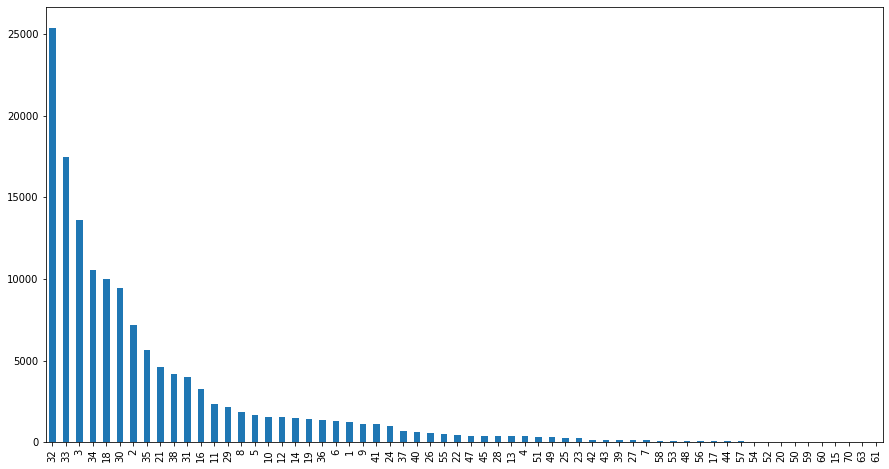

In [296]:
#Here we plot the number of ocurrences of each violations for a quick visualization of the situation
vio["Violation ID"].dropna(inplace=True)
vio["Violation ID"].value_counts().plot.bar(figsize = [15,8])

So what are the main violations we observe ?\
32: \
33: \
3: \
34: \
18: \
30: \
2: \
35: \
21: \
38: \
31: \
16: 

**Creating working dataset**



In [164]:
food_inspections_resto = food_inspections.copy()

In [165]:
count = food_inspections_resto.groupby('License #')['Inspection ID'].count()

food_inspections_resto = pd.merge(food_inspections_resto, count, on='License #')\
    .rename(columns={'Inspection ID_y':'# of Inspections','Inspection ID_x':'Inspection ID'})\
    .drop(['date','Inspection ID','DBA Name','AKA Name','Violations','Results','Inspection Type','Location'], axis=1)

In [166]:
food_inspections_resto.head()

,License #,Facility Type,Risk,Address,Latitude,Longitude,Violation Count,# of Inspections
0,2694640.0,Restaurant,Risk 2 (Medium),200 N GREEN ST,41.885699,-87.648789,1.0,1
1,2475982.0,Grocery Store,Risk 3 (Low),3459 W OGDEN AVE,41.855266,-87.712402,1.0,2
2,2475982.0,Grocery Store,Risk 3 (Low),3459 W OGDEN AVE,41.855266,-87.712402,1.0,2
3,2698627.0,Daycare Above and Under 2 Years,Risk 1 (High),4255-4259 S ARCHER AVE,41.816005,-87.700893,1.0,1
4,2622418.0,Mobile Food Preparer,Risk 2 (Medium),2300 S THROOP ST,41.850451,-87.658798,2.0,3


In [167]:
print('Number of rows to be deleted: {}'.format(food_inspections_resto[food_inspections_resto.duplicated()].shape))
food_inspections_resto = food_inspections_resto.drop_duplicates()
print('Number of rows in dataset after deletion: {}'.format(food_inspections_resto.shape))

Number of rows to be deleted: (155934, 8)
Number of rows in dataset after deletion: (37530, 8)


In [168]:
food_inspections_resto.head()

,License #,Facility Type,Risk,Address,Latitude,Longitude,Violation Count,# of Inspections
0,2694640.0,Restaurant,Risk 2 (Medium),200 N GREEN ST,41.885699,-87.648789,1.0,1
1,2475982.0,Grocery Store,Risk 3 (Low),3459 W OGDEN AVE,41.855266,-87.712402,1.0,2
3,2698627.0,Daycare Above and Under 2 Years,Risk 1 (High),4255-4259 S ARCHER AVE,41.816005,-87.700893,1.0,1
4,2622418.0,Mobile Food Preparer,Risk 2 (Medium),2300 S THROOP ST,41.850451,-87.658798,2.0,3
7,2698572.0,Restaurant,Risk 1 (High),300 N LA SALLE ST STE 110,41.887529,-87.632647,0.0,1


**Plot Geographical loc of restaurants**

In [169]:
import os
import pandas as pd
import json

import folium

In [170]:
folium.__version__ == '0.10.0'

True

In [171]:
chicago_coord = [41.85, -87.7]

In [172]:
m = folium.Map(location=chicago_coord)
m

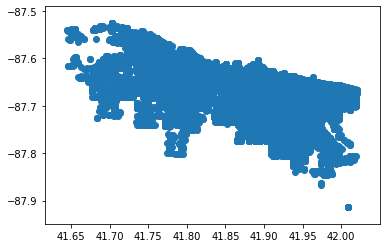

In [173]:
latitudes = food_inspections_resto.Latitude
longitudes = food_inspections_resto.Longitude

plt.figure()
plt.scatter(latitudes,longitudes)

In [174]:
# Need more data cleaning
food_inspections_resto = food_inspections_resto.dropna()

In [175]:
for index, row in food_inspections_resto.iterrows():
    if index < 1000:
        folium.Marker([row["Latitude"], row["Longitude"]], popup=str(index)).add_to(m)
    else: 
        break

In [176]:
m

**Map with markers of each type of risk reported**

In [332]:
#Separation of the dataset depending on the risk level
risk1 = food_inspections[food_inspections["Risk"]=='Risk 1 (High)'].copy()
risk2 = food_inspections[food_inspections["Risk"]=='Risk 2 (Medium)'].copy()
risk3 = food_inspections[food_inspections["Risk"]=='Risk 3 (Low)'].copy()

In [333]:
risk1.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,test
4,2320757,GADS HILL CENTER,GADS HILL CENTER,2698627.0,Daycare Above and Under 2 Years,Risk 1 (High),4255-4259 S ARCHER AVE,10/2019,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.816005,-87.700893,"{'latitude': '-87.70089338917239', 'longitude'...",23207572698627.010/2019
6,2320795,TBD,THE EXCHANGE,2698572.0,Restaurant,Risk 1 (High),300 N LA SALLE ST STE 110,10/2019,License,Pass,NaN,41.887529,-87.632647,"{'latitude': '-87.63264683652446', 'longitude'...",23207952698572.010/2019
7,2320768,The Manor,The Manor,22971.0,Restaurant,Risk 1 (High),4152-4158 W 47TH ST,10/2019,Canvass,No Entry,NaN,41.807924,-87.728164,"{'latitude': '-87.72816394877388', 'longitude'...",232076822971.010/2019
8,2320762,VIREVA NURSEY SCHOOL,VIREVA NURSEY SCHOOL,2215871.0,Children's Services Facility,Risk 1 (High),1935 W 51ST ST,10/2019,License Re-Inspection,Pass,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,41.801134,-87.673444,"{'latitude': '-87.6734440144631', 'longitude':...",23207622215871.010/2019
11,2320643,AVENIDA DEL SABOR,AVENIDA DEL SABOR,2488459.0,Restaurant,Risk 1 (High),5805 W DIVERSEY AVE,10/2019,Canvass,Out of Business,NaN,41.931095,-87.771344,"{'latitude': '-87.77134438272313', 'longitude'...",23206432488459.010/2019


In [426]:
#new map for the risks
riskmap = folium.Map(location=chicago_coord)
riskmap

In [427]:
risk1.shape[0]

139732

In [428]:
#Preparation for use of latitude and longitude for markers
risk1['Latitude'].reset_index(drop=True, inplace=True)
risk1['Latitude'].dropna(inplace=True)
risk1['Longitude'].reset_index(drop=True, inplace=True)
risk1['Longitude'].dropna(inplace=True)

risk2['Latitude'].reset_index(drop=True, inplace=True)
risk2['Latitude'].dropna(inplace=True)
risk2['Longitude'].reset_index(drop=True, inplace=True)
risk2['Longitude'].dropna(inplace=True)

risk3['Latitude'].reset_index(drop=True, inplace=True)
risk3['Latitude'].dropna(inplace=True)
risk3['Longitude'].reset_index(drop=True, inplace=True)
risk3['Longitude'].dropna(inplace=True)

In [429]:
#plot
for i in range(100):
    risk1_location = [risk1['Latitude'][i], risk1['Longitude'][i]]
    folium.Marker(risk1_location, popup="High Risk", icon=folium.Icon(color ='red', icon = 'map-marker')).add_to(riskmap)

In [430]:
riskmap